In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm

import math
from matplotlib.ticker import MaxNLocator

Scenarios saved to /root/Downloads/OECD_benchmark_scenarios.csv
Plot saved to /root/Downloads/OECD_benchmark_scenarios.pdf


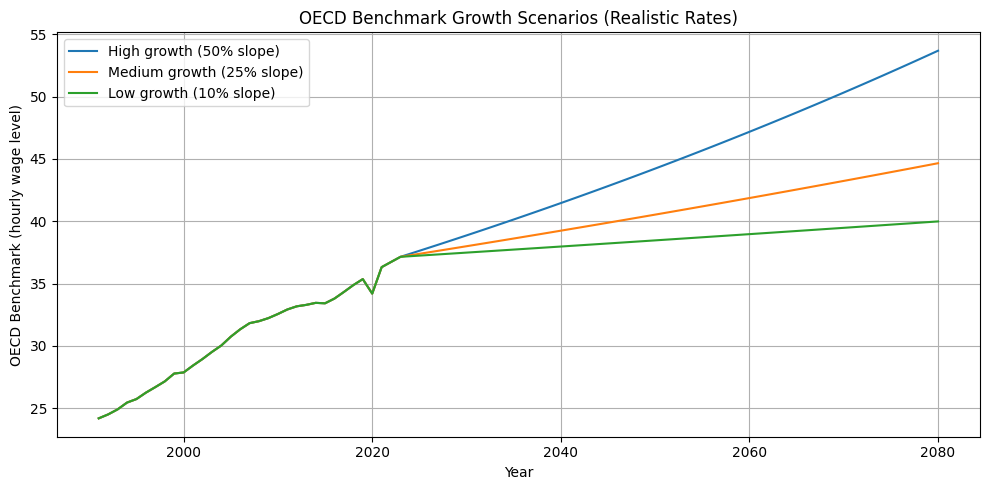

In [36]:
# ================================================
# 1. LOAD & LOG‑TRANSFORM YOUR WAGE DATA
# ================================================
df = pd.read_csv(os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Countries_Wages_Estimates_Finals_GOOD_new.csv'))
df['log_wage'] = np.log(df['estimated_hourly_wage'])

# ================================================
# 2. COMPUTE HISTORICAL OECD BENCHMARK (1991–2023)
# ================================================
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States'
}

hist = (
    df[df['country'].isin(oecd) & df['year'].between(1991, 2023)]
      .groupby('year')['log_wage']
      .mean()
      .rename('benchmark_log')
      .to_frame()
)

years_hist = hist.index.values            # [1991 … 2023]
loghist    = hist['benchmark_log'].values # log‐benchmark
last_year  = years_hist[-1]
last_log   = loghist[-1]

# ================================================
# 3. FIT HIGH‑GROWTH LINEAR TREND ON LOG
# ================================================
lin_model = LinearRegression().fit(
    years_hist.reshape(-1,1),
    loghist
)
slope_lin     = lin_model.coef_[0]
intercept_lin = lin_model.intercept_

# ================================================
# 4. DEFINE “REALISTIC” HIGH/MEDIUM/LOW SLOPES
#    High = 50% of hist slope (~2% p.a.)
#    Medium = 25% (~1% p.a.)
#    Low = 10% (~0.4% p.a.)
# ================================================
high_slope     = 0.50 * slope_lin
high_intercept = last_log - high_slope * last_year

med_slope      = 0.25 * slope_lin
med_intercept  = last_log - med_slope * last_year

low_slope      = 0.10 * slope_lin
low_intercept  = last_log - low_slope * last_year

# ================================================
# 5. FORECAST 2024–2080
# ================================================
extrap_year = 2080
years_fut   = np.arange(2024, extrap_year+1)

high_log   = high_slope  * years_fut + high_intercept
medium_log = med_slope   * years_fut + med_intercept
low_log    = low_slope    * years_fut + low_intercept

# ================================================
# 6. CONCATENATE & EXPONENTIATE BACK TO LEVELS
# ================================================
years_full      = np.concatenate([years_hist,    years_fut])
bench_high      = np.exp(np.concatenate([loghist,    high_log]))
bench_medium    = np.exp(np.concatenate([loghist,    medium_log]))
bench_low       = np.exp(np.concatenate([loghist,    low_log]))

# ================================================
# 7. BUILD A DATAFRAME & SAVE
# ================================================
bench_df = pd.DataFrame({
    'year':             years_full,
    'benchmark_high':   bench_high,
    'benchmark_medium': bench_medium,
    'benchmark_low':    bench_low,
})

# Define the output CSV path
out_csv = os.path.expanduser('~/Downloads/OECD_benchmark_scenarios.csv')
# Get the directory from the output path
out_dir = os.path.dirname(out_csv)
# Create the directory if it doesn't exist
os.makedirs(out_dir, exist_ok=True)

# Save the DataFrame to CSV
bench_df.to_csv(out_csv, index=False)
print(f"Scenarios saved to {out_csv}")

# ================================================
# 8. PLOT THE THREE SCENARIOS
# ================================================
plt.figure(figsize=(10, 5))
plt.plot(bench_df['year'], bench_df['benchmark_high'],   color='C0', label='High growth (50% slope)')
plt.plot(bench_df['year'], bench_df['benchmark_medium'], color='C1', label='Medium growth (25% slope)')
plt.plot(bench_df['year'], bench_df['benchmark_low'],    color='C2', label='Low growth (10% slope)')
plt.xlabel('Year')
plt.ylabel('OECD Benchmark (hourly wage level)')
plt.title('OECD Benchmark Growth Scenarios (Realistic Rates)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Save the figure too:
out_pdf = os.path.expanduser('~/Downloads/OECD_benchmark_scenarios.pdf')
plt.savefig(out_pdf, dpi=300)
print(f"Plot saved to {out_pdf}")

plt.show()


# Lesotho

In [42]:
# Decide which variable to be included
lesotho_var = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Variables_Lesotho.csv', usecols=['country', 'year', 'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)'])
lesotho_var = lesotho_var.rename(columns={'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)': 'Labor Force'})

# Merge with working DataFrame
df_var = df.copy()
df_var = df_var.merge(lesotho_var, on=['country', 'year'], how='left')


# Argentina

In [43]:
# Decide which variable to be included
arg_var = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Variables_Argentina.csv', usecols=['country', 'year', 'Inflation, GDP deflator (annual %)'])
arg_var = arg_var.rename(columns={'Inflation, GDP deflator (annual %)': 'Inflation'})

# Merge with working DataFrame
df_var2 = df_var.copy()
df_var2 = df_var.merge(arg_var, on=['country', 'year'], how='left')

# Azerbaijan

In [44]:
# Decide which variable to be included
az_var = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Variables_Azerbaijan.csv', usecols=['country', 'year', 'Agriculture, forestry, and fishing, value added (% of GDP)'])
az_var = az_var.rename(columns={'Agriculture, forestry, and fishing, value added (% of GDP)': 'Waterstress'})

# Merge with working DataFrame
df_var3 = df_var2.copy()
df_var3 = df_var3.merge(az_var, on=['country', 'year'], how='left')

# Burkina Faso

In [45]:
# Decide which variable to be included
bf_var = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Variables_Burkina%20Faso.csv', usecols=['country', 'year', 'Country where conflict took place - Conflict type: all'])
bf_var = bf_var.rename(columns={'Country where conflict took place - Conflict type: all': 'Conflict Dummy'})

# Merge with working DataFrame
df_var4 = df_var3.copy()
df_var4 = df_var4.merge(bf_var, on=['country', 'year'], how='left')

# Central African Republic

In [48]:
# Decide which variable to be included
cap_var = pd.read_csv('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Variables_Central%20African%20Republic.csv', usecols=['country', 'year', 'Country where conflict took place - Conflict type: all'])
cap_var = cap_var.rename(columns={'Country where conflict took place - Conflict type: all': 'Conflict Dummy'})

# Merge with working DataFrame
df_var5 = df_var4.copy()
df_var5 = df_var5.merge(cap_var, on=['country', 'year', 'Conflict Dummy'], how='left')

In [49]:
df_var5.head()

,iso_code,country,year,empratio,gdpcap,laborshare,whours,empratio_fraction,estimated_hourly_wage,log_estimated_hourly_wage,log_wage,Labor Force,Inflation,Waterstress,Conflict Dummy
0,AGO,Angola,1991,64.287,7218.441432,0.284385,2100.0,0.64287,1.520573,0.419087,0.419087,NaN,NaN,NaN,NaN
1,AGO,Angola,1992,64.229,6578.068575,0.284385,2100.0,0.64229,1.386929,0.327092,0.327092,NaN,NaN,NaN,NaN
2,AGO,Angola,1993,63.937,4843.155884,0.284385,2100.0,0.63937,1.025801,0.025474,0.025474,NaN,NaN,NaN,NaN
3,AGO,Angola,1994,63.965,4751.471649,0.284385,2100.0,0.63965,1.005941,0.005924,0.005924,NaN,NaN,NaN,NaN
4,AGO,Angola,1995,64.298,5284.703133,0.284385,2100.0,0.64298,1.113038,0.107093,0.107093,NaN,NaN,NaN,NaN


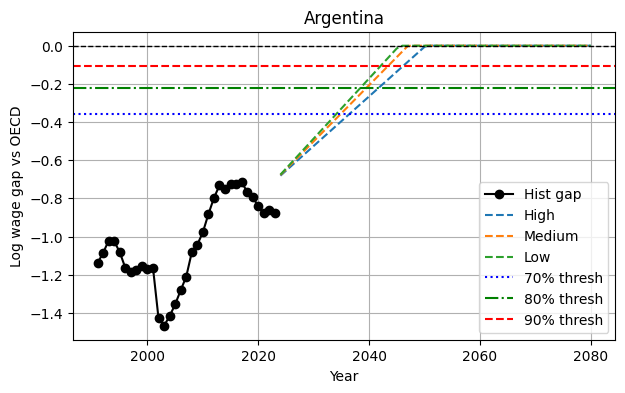

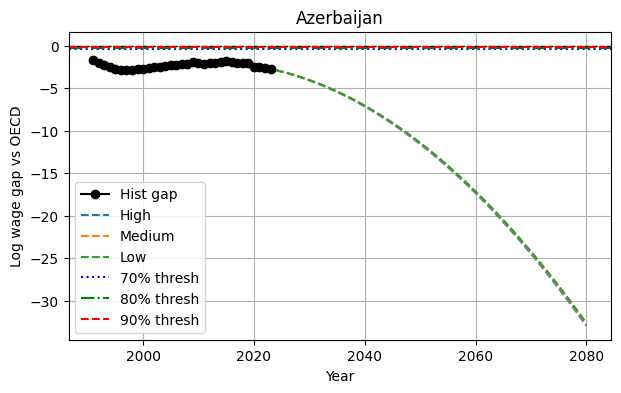

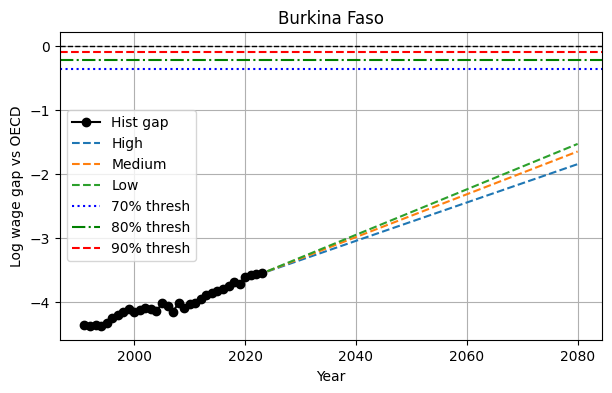

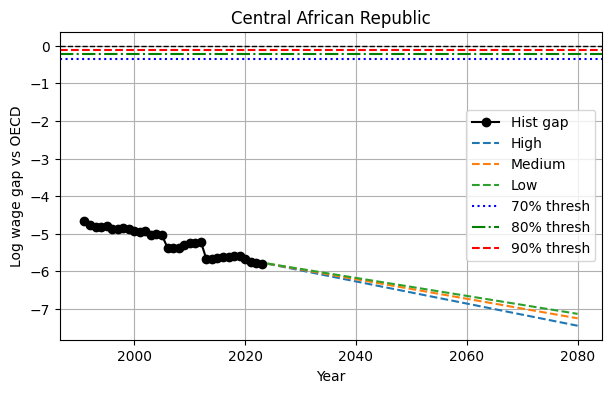

<ipython-input-54-1e99a65f63ec>:286: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, Xtr, Ytr, p0=p0,


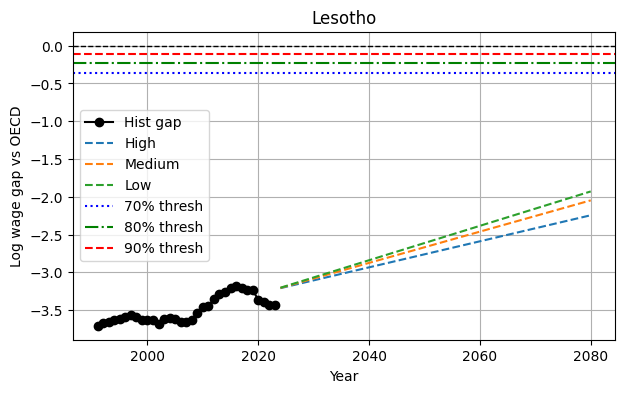

Raw summary → /root/Downloads/V30_convergence_three_scenarios_nonOECD_plateau_summary.csv
Convergers → /root/Downloads/V30_convergers_low70.csv
Divergers  → /root/Downloads/V30_divergers_low70.csv


In [54]:
# Country specific regression (with new variable)

# ── 1. LOAD DATA & OECD SCENARIOS ─────────────────────────────────────────────
df_var5['log_wage'] = np.log(df_var5['estimated_hourly_wage'])
df_var5['country'] = df_var5['country'].str.replace('\u00A0', ' ').str.strip()

bench_df = pd.read_csv(os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/oecd_benchmark_scenarios.csv'))

# ── 2. EXCLUDE OECD COUNTRIES & MERGE SCENARIOS ─────────────────────────────────
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States'
}
df_2 = (
    df_var5
      .merge(bench_df, on='year', how='left')
      .query("country not in @oecd")
      .dropna(subset=['benchmark_high'])
)

# ── 3. MODEL CANDIDATES & ROLLING-ORIGIN SPLITS ──────────────────────────────────
def exp_decay(tc, A, k, C):
    return A * np.exp(-k*tc) + C

def logistic(tc, L, k, C):
    return C + L / (1 + np.exp(-k*tc))

tscv = TimeSeriesSplit(n_splits=5)

# ── 4. THRESHOLDS & OUTPUT SETUP ───────────────────────────────────────────────
extrap_year = bench_df['year'].max()
thr_levels  = [0.7, 0.8, 0.9]
log_thr     = {lvl: np.log(lvl) for lvl in thr_levels}

results = []

# ── 5. LOOP OVER NON-OECD COUNTRIES & PLOT ──────────────────────────────────────
from matplotlib.backends.backend_pdf import PdfPages
plots = []  # collect figures here

for country, sub in df_2.groupby('country'):
    sub = sub.sort_values('year')
    if len(sub) < 6:
        continue

    years_hist = sub['year'].values
    t0         = years_hist.min()
    logw_hist  = sub['log_wage'].values

    # Initialize tc_hist and pipelines_country for the general case
    # tc_hist will be updated in special cases
    tc_hist = (years_hist - t0).reshape(-1, 1) # Default to time only
    pipelines_country = {
        'Linear': LinearRegression(),
        'Quadratic': Pipeline([
            ('poly', PolynomialFeatures(2)),
            ('lr', LinearRegression())
        ]),
        'Sqrt': Pipeline([
            ('sqrt', FunctionTransformer(np.sqrt, validate=False)),
            ('lr', LinearRegression())
        ])
    }
    skip_nonlinear = False # Default to including nonlinear models

    # Prepare default tc_fut (time only)
    years_fut = np.arange(years_hist.max()+1, extrap_year+1)
    tc_fut = (years_fut - t0).reshape(-1, 1)


    # ── Special case handling: potentially update tc_hist, pipelines_country, and tc_fut ──
    if country == 'Lesotho':
        # Check if the variable exists, has non-nulls, and the last value is not NaN
        if 'Labor Force' in sub.columns and sub['Labor Force'].notnull().any() and not pd.isna(sub['Labor Force'].values[-1]):
            X_hist = pd.DataFrame({
                't': years_hist - t0,
                'Labor Force': sub['Labor Force'].values
            })
            tc_hist = X_hist.values # Update tc_hist to include Labor Force

            pipelines_country = { # Update pipelines_country for this special case
                'Linear': LinearRegression(),
                'Quadratic': Pipeline([
                    ('poly', PolynomialFeatures(2)),
                    ('lr', LinearRegression())
                ])
            }
            skip_nonlinear = True  # Skip exp_decay and logistic for Lesotho

            # Prepare tc_fut for Lesotho with Labor Force
            last_value_lf = sub['Labor Force'].values[-1]
            labor_force_fut = np.full_like(years_fut, fill_value=last_value_lf, dtype=float)
            X_fut_lesotho = pd.DataFrame({
                  't': years_fut - t0,
                  'Labor Force': labor_force_fut
            })
            tc_fut = X_fut_lesotho.values # Update tc_fut for Lesotho
        else:
             print(f"Warning: Skipping special model for {country} due to missing or NaN data.")


    # ── Special case for Argentina ──
    elif country == 'Argentina':
         # Check if the variable exists, has non-nulls, and the last value is not NaN
         if 'Inflation' in sub.columns and sub['Inflation'].notnull().any() and not pd.isna(sub['Inflation'].values[-1]):
            X_hist = pd.DataFrame({
                't': years_hist - t0,
                'Inflation': sub['Inflation'].values
            })
            tc_hist = X_hist.values

            pipelines_country = {
                'Linear': LinearRegression(),
                'Quadratic': Pipeline([
                    ('poly', PolynomialFeatures(2)),
                    ('lr', LinearRegression())
                ])
            }
            skip_nonlinear = True

            # Prepare tc_fut for Argentina
            last_value_infl = sub['Inflation'].values[-1]
            inflation_fut = np.full_like(years_fut, fill_value=last_value_infl, dtype=float)
            X_fut_arg = pd.DataFrame({
                  't': years_fut - t0,
                  'Inflation': inflation_fut
            })
            tc_fut = X_fut_arg.values
         else:
             print(f"Warning: Skipping special model for {country} due to missing or NaN data.")


    # ── Special case for Azerbaijan ──
    elif country == 'Azerbaijan':
         # Check if the variable exists, has non-nulls, and the last value is not NaN
         if 'Waterstress' in sub.columns and sub['Waterstress'].notnull().any() and not pd.isna(sub['Waterstress'].values[-1]):
            X_hist = pd.DataFrame({
                't': years_hist - t0,
                'Waterstress': sub['Waterstress'].values
            })
            tc_hist = X_hist.values

            pipelines_country = {
                'Linear': LinearRegression(),
                'Quadratic': Pipeline([
                    ('poly', PolynomialFeatures(2)),
                    ('lr', LinearRegression())
                ])
            }
            skip_nonlinear = True

            # Prepare tc_fut for Azerbaijan
            last_value_ws = sub['Waterstress'].values[-1]
            waterstress_fut = np.full_like(years_fut, fill_value=last_value_ws, dtype=float)
            X_fut_az = pd.DataFrame({
                  't': years_fut - t0,
                  'Waterstress': waterstress_fut
            })
            tc_fut = X_fut_az.values
         else:
             print(f"Warning: Skipping special model for {country} due to missing or NaN data.")


    # ── Special case for Burkina Faso ──
    elif country == 'Burkina Faso':
         # Check if the variable exists, has non-nulls, and the last value is not NaN
         if 'Conflict Dummy' in sub.columns and sub['Conflict Dummy'].notnull().any() and not pd.isna(sub['Conflict Dummy'].values[-1]):
            X_hist = pd.DataFrame({
                't': years_hist - t0,
                'Conflict Dummy': sub['Conflict Dummy'].values
            })
            tc_hist = X_hist.values

            pipelines_country = {
                'Linear': LinearRegression(),
                'Quadratic': Pipeline([
                    ('poly', PolynomialFeatures(2)),
                    ('lr', LinearRegression())
                ])
            }
            skip_nonlinear = True

            # Prepare tc_fut for Burkina Faso
            last_value_cd = sub['Conflict Dummy'].values[-1]
            conflict_fut = np.full_like(years_fut, fill_value=last_value_cd, dtype=float)
            X_fut_bf = pd.DataFrame({
                  't': years_fut - t0,
                  'Conflict Dummy': conflict_fut
            })
            tc_fut = X_fut_bf.values
         else:
             print(f"Warning: Skipping special model for {country} due to missing or NaN data.")


    # ── Special case for Central African Republic ──
    elif country == 'Central African Republic':
         # Check if the variable exists, has non-nulls, and the last value is not NaN
         if 'Conflict Dummy' in sub.columns and sub['Conflict Dummy'].notnull().any() and not pd.isna(sub['Conflict Dummy'].values[-1]):
            X_hist = pd.DataFrame({
                't': years_hist - t0,
                'Conflict Dummy': sub['Conflict Dummy'].values
            })
            tc_hist = X_hist.values

            pipelines_country = {
                'Linear': LinearRegression(),
                'Quadratic': Pipeline([
                    ('poly', PolynomialFeatures(2)),
                    ('lr', LinearRegression())
                ])
            }
            skip_nonlinear = True

            # Prepare tc_fut for Central African Republic
            last_value_cd = sub['Conflict Dummy'].values[-1]
            conflict_fut = np.full_like(years_fut, fill_value=last_value_cd, dtype=float)
            X_fut_car = pd.DataFrame({
                  't': years_fut - t0,
                  'Conflict Dummy': conflict_fut
            })
            tc_fut = X_fut_car.values
         else:
             print(f"Warning: Skipping special model for {country} due to missing or NaN data.")


    # ── General Case or Fallback if Special Model Skipped ─────
    # If the special model was skipped, tc_hist and tc_fut remain the time-only versions.


    # a) Rolling-origin CV for candidate models
    candidate_errors = {}
    for name, model in pipelines_country.items():
        errs = []
        for tr, te in tscv.split(tc_hist):
            # Ensure X_train, y_train, X_test match the dimensions expected by the model
            # Handle both single-feature (time only) and multi-feature cases
            Xtr = tc_hist[tr]
            Xte = tc_hist[te]

            # Check if Xtr is not empty before fitting
            if len(Xtr) > 0:
                try:
                    model.fit(Xtr, logw_hist[tr])
                    # Check if Xte is not empty before predicting and calculating error
                    if len(Xte) > 0:
                         errs.append(mean_squared_error(
                             logw_hist[te], model.predict(Xte)
                         ))
                    else:
                         # If test set is empty for a split, this split cannot contribute to error
                         pass
                except Exception as e:
                    # Catch potential fitting errors (e.g., singular matrix for LinearRegression with few data points)
                    # print(f"Warning: Fitting failed for {country} with {name} during CV split {tr}: {e}") # Optional: uncomment for debugging
                    errs=[] # Invalidate this model for this country if fitting fails on any split
                    break
            else:
                 # If training set is empty for a split, this model cannot be fitted
                 errs=[] # Invalidate this model for this country
                 break # No need to continue splits for this model


        if errs: # Only add to candidate_errors if there were successful splits
            candidate_errors[name] = np.mean(errs)


    # b) CV for ExpDecay & Logistic
    if not skip_nonlinear:
        for name, func in [('ExpDecay', exp_decay), ('Logistic', logistic)]:
            errs = []
            for tr, te in tscv.split(tc_hist):
                # Ensure Xtr is 1D for curve_fit
                Xtr = tc_hist[tr].ravel(); Ytr = logw_hist[tr]
                if len(Xtr) > 0: # Check if training set is not empty
                    try:
                        p0 = [Ytr[0]-Ytr[-1],0.02,Ytr[-1]] if name=='ExpDecay' and len(Ytr)>1 else (
                             [0.1, 0.02, Ytr[-1]] if name=='ExpDecay' else
                             [Ytr.max()-Ytr.min(),0.1,Ytr.min()] if len(Ytr)>1 else
                             [0.1, 0.1, Ytr[0]] # Fallback p0 for single point or other issues
                        )
                        # Ensure p0 bounds match for ExpDecay and Logistic
                        bounds = ([0,0,-np.inf],[np.inf,1,np.inf]) if name=='ExpDecay' else ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]) # Adjusted bounds for Logistic

                        popt, _ = curve_fit(func, Xtr, Ytr, p0=p0,
                                            bounds=bounds, maxfev=10000)
                        # Ensure Xte is 1D for prediction with func
                        Xte = tc_hist[te].ravel()
                        if len(Xte) > 0: # Check if test set is not empty
                            preds = func(Xte, *popt)
                            errs.append(mean_squared_error(logw_hist[te], preds))
                    except Exception as e: # Catch potential errors during curve_fit or predict
                        # print(f"Warning: curve_fit failed for {country} with {name} during CV split {tr}: {e}") # Optional: uncomment for debugging
                        errs=[] # If curve_fit fails for any split, invalidate this model for this country
                        break
                else:
                    errs=[] # If training set is empty, invalidate the model
                    break # No need to continue splits for this model

            if errs:
                candidate_errors[name] = np.mean(errs)


    # c) Select & refit best
    if not candidate_errors: # Handle case where all models failed CV
        print(f"Warning: No valid models found for {country}. Skipping.")
        continue

    best = min(candidate_errors, key=candidate_errors.get)

    # Prepare the data for refitting based on the structure expected by the best model type
    if best in pipelines_country:
         X_full_refit = tc_hist # Use the potentially multi-dimensional tc_hist
         try:
              final_model = pipelines_country[best].fit(X_full_refit, logw_hist) # Fit on full history
              predict = lambda X: final_model.predict(X)
         except Exception as e:
              print(f"Error: Refitting scikit-learn model {best} for {country} failed: {e}. Skipping country.")
              continue # Skip this country if refitting fails

    else: # ExpDecay or Logistic
         fn = exp_decay if best=='ExpDecay' else logistic
         # Refit curve_fit model on full history
         X_full_refit = tc_hist.ravel(); Y_full_refit = logw_hist # curve_fit expects 1D
         p0 = [Y_full_refit[0]-Y_full_refit[-1],0.02,Y_full_refit[-1]] if best=='ExpDecay' and len(Y_full_refit)>1 else (
             [0.1, 0.02, Y_full_refit[-1]] if best=='ExpDecay' else
             [Y_full_refit.max()-Y_full_refit.min(),0.1,Y_full_refit.min()] if len(Y_full_refit)>1 else
             [0.1, 0.1, Y_full_refit[0]]
         )
         # Adjusted bounds for Logistic
         bounds = ([0,0,-np.inf],[np.inf,1,np.inf]) if best=='ExpDecay' else ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
         try:
              popt, _ = curve_fit(fn, X_full_refit, Y_full_refit, p0=p0,
                                  bounds=bounds, maxfev=10000)
              predict = lambda X, fn=fn, popt=popt: fn(X.ravel(),*popt) # Ensure X is 1D for fn
         except Exception as e:
              print(f"Error: Refitting curve_fit model {best} for {country} failed: {e}. Skipping country.")
              continue # Skip this country if refitting fails


    # d) Forecast & plateau cap
    # tc_fut was already prepared based on the special case or general case before the CV loop
    tc_fut_predict = tc_fut # Use the prepared tc_fut for prediction


    logw_fut  = predict(tc_fut_predict) # Pass the prepared tc_fut to predict

    # Recalculate gaps_hist to ensure it matches the years available for 'benchmark_high'
    # Also handle potential NaNs in logw_hist if df_var5 had missing values, though dropna(subset=['benchmark_high'])
    # on df_2 should have removed rows where benchmark_high was missing.
    # We need to align logw_hist with benchmark_high by year.
    hist_years_with_bench = sub.dropna(subset=['benchmark_high'])['year'].values
    logw_hist_aligned = sub.set_index('year').reindex(hist_years_with_bench)['log_wage'].values
    benchmark_hist_aligned = sub.set_index('year').reindex(hist_years_with_bench)['benchmark_high'].values

    if len(logw_hist_aligned) > 0 and len(benchmark_hist_aligned) > 0:
       # Ensure both arrays have the same non-NaN elements for accurate subtraction
       aligned_idx = np.where(~np.isnan(logw_hist_aligned) & ~np.isnan(benchmark_hist_aligned))[0]
       if len(aligned_idx) > 0:
           gaps_hist = logw_hist_aligned[aligned_idx] - np.log(benchmark_hist_aligned[aligned_idx])
           # Update hist_years_with_bench to match the valid indices
           hist_years_with_bench = hist_years_with_bench[aligned_idx]
       else:
           gaps_hist = np.array([]) # No historical gaps if no aligned non-NaN data
           hist_years_with_bench = np.array([])
    else:
       gaps_hist = np.array([]) # No historical gaps if no aligned data
       hist_years_with_bench = np.array([])


    gaps_fut  = {}
    for s in ['high','medium','low']:
        # Reindex bench_df to match the years_fut for accurate alignment
        benchmark_values_fut = bench_df.set_index('year')[f'benchmark_{s}'].reindex(years_fut).values
        # Calculate raw gap only for years where both logw_fut and benchmark_values_fut are available
        valid_years_fut_mask = ~np.isnan(logw_fut) & ~np.isnan(benchmark_values_fut)
        if valid_years_fut_mask.any():
             raw = logw_fut[valid_years_fut_mask] - np.log(benchmark_values_fut[valid_years_fut_mask])
             # Initialize a full NaN array and fill in valid gap values
             full_gaps_fut_s = np.full_like(years_fut, np.nan, dtype=float)
             full_gaps_fut_s[valid_years_fut_mask] = np.minimum(raw, 0.0)
             gaps_fut[s] = full_gaps_fut_s
        else:
             gaps_fut[s] = np.full_like(years_fut, np.nan, dtype=float) # All NaNs if no valid data


    # e) Record summary, including gap_low_2080
    # Check if 'low' scenario gaps_fut has data before accessing [-1]
    gap_low_2080_val = np.nan # Default to NaN
    if 'low' in gaps_fut and len(gaps_fut['low']) > 0:
        # Find the last non-NaN value if any exist
        last_valid_gap_idx = np.where(~np.isnan(gaps_fut['low']))[0]
        if last_valid_gap_idx.size > 0:
             # Ensure this index is within the bounds of years_fut and gaps_fut['low']
             if last_valid_gap_idx[-1] < len(years_fut) and last_valid_gap_idx[-1] < len(gaps_fut['low']):
                 gap_low_2080_val = gaps_fut['low'][last_valid_gap_idx[-1]]
        # If the target year 2080 exists and is not NaN, use that specific value
        if extrap_year in years_fut:
             idx_2080 = np.where(years_fut == extrap_year)[0]
             if idx_2080.size > 0 and not np.isnan(gaps_fut['low'][idx_2080[0]]):
                  gap_low_2080_val = gaps_fut['low'][idx_2080[0]]


    row = {
        'country':     country,
        'best_model':  best,
        'cv_mse':      round(candidate_errors[best],4) if candidate_errors and best in candidate_errors else np.nan, # Check if best is in candidate_errors
        'gap_low_2080': round(gap_low_2080_val,4) if not np.isnan(gap_low_2080_val) else np.nan
    }
    for s, code in zip(['high','medium','low'], ['H','M','L']):
        for lvl in thr_levels:
            if s in gaps_fut and len(gaps_fut[s]) > 0:
                # Ensure gap_fut[s] and log(lvl) are comparable and handle NaNs
                # Find indices where the gap is greater than or equal to the log threshold
                idx = np.where(gaps_fut[s] >= np.log(lvl))[0]
                # Find the index of the first future year that meets the condition
                first_year_idx = idx[0] if idx.size > 0 else -1 # Use -1 to indicate no year found
                # Ensure the index is valid before accessing years_fut
                row[f'{code}-{int(lvl*100)}'] = str(years_fut[first_year_idx]) if first_year_idx != -1 and first_year_idx < len(years_fut) else 'X'
            else:
                 row[f'{code}-{int(lvl*100)}'] = 'X' # Mark as 'X' if no gap data was generated


    results.append(row)

    # f) Plot with thresholds
    fig, ax = plt.subplots(figsize=(7, 4))
    # Plot historical gaps only where they are not NaN
    if gaps_hist.size > 0 and hist_years_with_bench.size > 0:
         ax.plot(hist_years_with_bench, gaps_hist, 'ko-', label='Hist gap')

    for s, c in zip(['high','medium','low'], ['C0','C1','C2']):
        if s in gaps_fut and len(gaps_fut[s]) > 0:
            # Plot future gaps only where they are not NaN
            valid_fut_mask = ~np.isnan(gaps_fut[s])
            if valid_fut_mask.any():
                 ax.plot(years_fut[valid_fut_mask], gaps_fut[s][valid_fut_mask], '--', color=c, label=s.capitalize())

    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axhline(np.log(0.7), color='blue', linestyle=':', label='70% thresh')
    ax.axhline(np.log(0.8), color='green', linestyle='-.', label='80% thresh')
    ax.axhline(np.log(0.9), color='red', linestyle='--', label='90% thresh')
    ax.set_title(country)
    ax.set_xlabel('Year')
    ax.set_ylabel('Log wage gap vs OECD')
    ax.legend()
    ax.grid(True)

    # 🔍 Only show plots for selected countries
    show_plot_for = ['Lesotho', 'Argentina', 'Azerbaijan', 'Burkina Faso', 'Central African Republic']
    if country in show_plot_for:
        plt.show()
    else:
        plt.close(fig)


# ── 6. SAVE RAW SUMMARY CSV ───────────────────────────────────────────────────
out_raw = os.path.expanduser(
    '~/Downloads/V30_convergence_three_scenarios_nonOECD_plateau_summary.csv'
)
# Ensure results list is not empty before creating DataFrame
if results:
    df_res = pd.DataFrame(results)
    # Ensure output directory exists
    out_dir = os.path.dirname(out_raw)
    os.makedirs(out_dir, exist_ok=True)
    df_res.to_csv(out_raw, index=False)
    print("Raw summary →", out_raw)

    # ── 7. SPLIT INTO CONVERGERS / DIVERGERS & SAVE ────────────────────────────────
    # flag those that hit low-scenario 70% by 2080
    # Need to handle potential non-numeric 'L-70' values ('X')
    df_res['L-70_numeric'] = pd.to_numeric(df_res['L-70'], errors='coerce')
    df_res['converges_low70'] = df_res['L-70_numeric'].notna() # Converges if L-70 is a number (not 'X')

    # convergers: sort by year they cross L-70
    conv = df_res[df_res['converges_low70']].copy()
    conv = conv.sort_values('L-70_numeric').drop(columns='L-70_numeric')

    # divergers: those with X, sort by gap_low_2080 (closest to zero first), handle NaN gap_low_2080
    div = df_res[~df_res['converges_low70']].copy()
    # Sort by gap_low_2080, placing NaNs at the end
    div = div.sort_values('gap_low_2080', ascending=False, na_position='last')


    # save both
    out_conv = os.path.expanduser('~/Downloads/V30_convergers_low70.csv')
    out_div  = os.path.expanduser('~/Downloads/V30_divergers_low70.csv')
    # Ensure output directory exists for these files too
    out_dir_conv = os.path.dirname(out_conv)
    os.makedirs(out_dir_conv, exist_ok=True)
    out_dir_div = os.path.dirname(out_div)
    os.makedirs(out_dir_div, exist_ok=True)

    conv.to_csv(out_conv, index=False)
    div.to_csv(out_div,  index=False)
    print("Convergers →", out_conv)
    print("Divergers  →", out_div)
else:
    print("No results generated, skipping saving summary and splits.")

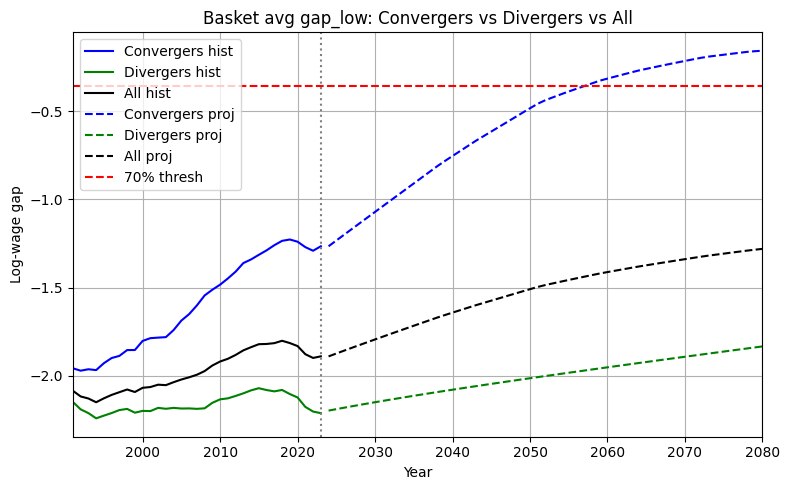

In [55]:
# ── 1) helper functions & CV setup ────────────────────────────────────────────
def exp_decay(tc, A, k, C): return A * np.exp(-k*tc) + C
def logistic(tc, L, k, C):  return C + L/(1+np.exp(-k*tc))

tscv = TimeSeriesSplit(n_splits=5)
pipelines = {
    'Linear': LinearRegression(),
    'Quadratic': Pipeline([('poly', PolynomialFeatures(2)),('lr',LinearRegression())]),
    'Sqrt': Pipeline([('sqrt', FunctionTransformer(np.sqrt,validate=False)),('lr',LinearRegression())])
}

# ── 2) load converger & diverger lists ───────────────────────────────────────
conv = pd.read_csv(os.path.expanduser('~/Downloads/V30_convergers_low70.csv'))
div  = pd.read_csv(os.path.expanduser('~/Downloads/V30_divergers_low70.csv'))
conv_countries = conv['country'].tolist()
div_countries  = div['country'].tolist()
all_countries  = list(set(conv_countries + div_countries))

# ── 3) load wage data & OECD benchmarks ──────────────────────────────────────
#df = pd.read_csv(os.path.expanduser(
#    '~/Documents/Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD.csv'
#))
df['log_wage'] = np.log(df['estimated_hourly_wage'])
df['country']  = df['country'].str.replace('\u00A0',' ').str.strip()

bench = pd.read_csv(os.path.expanduser(
    '~/Downloads/OECD_benchmark_scenarios.csv'
)).set_index('year')

# ── 4) prepare non-OECD merged df2 ────────────────────────────────────────────
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States'
}
df2 = (
    df.merge(bench, on='year', how='left')
      .query("country not in @oecd")
      .dropna(subset=['benchmark_low'])
)

# ── 5) global future-years vector ─────────────────────────────────────────────
years_fut = np.arange(2024, bench.index.max()+1)

# ── 6) function to build low-scenario gaps for any country list ──────────────
def build_low_gaps(country_list):
    low_gaps = {}
    for country in country_list:
        sub = df2[df2['country']==country].sort_values('year')
        if len(sub) < 6: continue

        # history arrays
        y       = sub['year'].values
        t0      = y.min()
        tc_hist = (y - t0).reshape(-1,1)
        lw_hist = sub['log_wage'].values

        # 1) CV to pick best model
        errs = {}
        for name,model in pipelines.items():
            mses=[]
            for tr,te in tscv.split(tc_hist):
                model.fit(tc_hist[tr], lw_hist[tr])
                mses.append(mean_squared_error(lw_hist[te], model.predict(tc_hist[te])))
            errs[name] = np.mean(mses)
        for name,fn in [('ExpDecay',exp_decay),('Logistic',logistic)]:
            mses=[]
            for tr,te in tscv.split(tc_hist):
                Xtr, Ytr = tc_hist[tr].ravel(), lw_hist[tr]
                p0 = [Ytr[0]-Ytr[-1],0.02,Ytr[-1]] if name=='ExpDecay' else [Ytr.max()-Ytr.min(),0.1,Ytr.min()]
                try:
                    p,_ = curve_fit(fn, Xtr, Ytr, p0=p0,
                                    bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
                    preds = fn(tc_hist[te].ravel(), *p)
                    mses.append(mean_squared_error(lw_hist[te], preds))
                except:
                    mses=[]
                    break
            if mses:
                errs[name] = np.mean(mses)

        # 2) refit best on full history
        best = min(errs, key=errs.get)
        if best in pipelines:
            model = pipelines[best].fit(tc_hist, lw_hist)
            predict = lambda X: model.predict(X)
        else:
            fn = exp_decay if best=='ExpDecay' else logistic
            p0 = [lw_hist[0]-lw_hist[-1],0.02,lw_hist[-1]] if best=='ExpDecay' else [lw_hist.max()-lw_hist.min(),0.1,lw_hist.min()]
            p,_ = curve_fit(fn, tc_hist.ravel(), lw_hist, p0=p0,
                            bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
            predict = lambda X,fn=fn,p=p: fn(X.ravel(), *p)

        # 3) last observed gap_low
        hist_bench = np.log( bench.reindex(y)['benchmark_low'].values )
        last_gap   = (lw_hist - hist_bench)[-1]

        # 4) forecast & raw gap_low
        tc_f = (years_fut - t0).reshape(-1,1)
        lw_f = predict(tc_f)
        raw  = lw_f - np.log( bench.reindex(years_fut)['benchmark_low'].values )
        gap_f = np.minimum(raw, 0.0)

        # 5) stitch continuity
        gap_f = gap_f - gap_f[0] + last_gap

        low_gaps[country] = gap_f

    return low_gaps

# ── 7) build projected gaps for each basket ─────────────────────────────────
low_gaps_conv = build_low_gaps(conv_countries)
low_gaps_div  = build_low_gaps(div_countries)
low_gaps_all  = build_low_gaps(all_countries)

# ── 8) turn into DataFrames & compute basket means ─────────────────────────
gap_conv_df = pd.DataFrame(low_gaps_conv, index=years_fut)
gap_div_df  = pd.DataFrame(low_gaps_div,  index=years_fut)
gap_all_df  = pd.DataFrame(low_gaps_all,  index=years_fut)

avg_conv_fut = gap_conv_df.mean(axis=1)
avg_div_fut  = gap_div_df.mean(axis=1)
avg_all_fut  = gap_all_df.mean(axis=1)

# ── 9) compute historical basket averages ───────────────────────────────────
def basket_hist(countries):
    sub = df2[df2['country'].isin(countries)].copy()
    sub['gap_low'] = np.log(sub['estimated_hourly_wage']) - np.log(sub['benchmark_low'])
    return sub.groupby('year')['gap_low'].mean()

hist_conv = basket_hist(conv_countries)
hist_div  = basket_hist(div_countries)
hist_all  = basket_hist(all_countries)

# ── 10) plot all three baskets on one graph ─────────────────────────────────
plt.figure(figsize=(8,5))
plt.plot(hist_conv.index, hist_conv.values, 'b-', label='Convergers hist')
plt.plot(hist_div.index,  hist_div.values,  'g-', label='Divergers hist')
plt.plot(hist_all.index,  hist_all.values,  'k-', label='All hist')

plt.plot(years_fut, avg_conv_fut, 'b--', label='Convergers proj')
plt.plot(years_fut, avg_div_fut,  'g--', label='Divergers proj')
plt.plot(years_fut, avg_all_fut,  'k--', label='All proj')

plt.axvline(2023, color='gray', linestyle=':')
plt.axhline(np.log(0.7), color='red', linestyle='--', label='70% thresh')
plt.xlim(1991, bench.index.max())
plt.xlabel('Year'); plt.ylabel('Log-wage gap')
plt.title('Basket avg gap_low: Convergers vs Divergers vs All')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.expanduser('~/Downloads/New_basket_avg_gap_low.pdf'), format='pdf', dpi=300)

plt.show()


In [56]:
# Load data and take logs
#df = pd.read_csv(os.path.expanduser('~/Documents/Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD.csv'))
df['log_wage'] = np.log(df['estimated_hourly_wage'])

# ──────────────────────────────────────────────────────────────────────────────
# 1. Sigma Convergence
#    Annual dispersion (standard deviation) of log‐wages
# ──────────────────────────────────────────────────────────────────────────────
sigma_series = df.groupby('year')['log_wage'].std().reset_index(name='sigma')

plt.figure(figsize=(8,4))
plt.plot(
    sigma_series['year'],
    sigma_series['sigma'],
    color='C0',
    linewidth=2,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=1.5
)
plt.title('Sigma Convergence: Dispersion of Log Wages Over Time', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Std. Dev. of Log Wages', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

sigma_pdf = os.path.expanduser('~/Downloads/sigma_convergence_GOOD.pdf')
plt.savefig(sigma_pdf, format='pdf')
plt.close()

# ──────────────────────────────────────────────────────────────────────────────
# 2. Beta Convergence
#    Cross‐sectional regression of annualized growth on initial log wage
# ──────────────────────────────────────────────────────────────────────────────
start, end = df['year'].min(), df['year'].max()
pivot = df.pivot(index='country', columns='year', values='log_wage')
mask = pivot[start].notna() & pivot[end].notna()
pivot = pivot.loc[mask, [start, end]]

growth = (pivot[end] - pivot[start]) / (end - start)
initial = pivot[start]

X = sm.add_constant(initial)
beta_model = sm.OLS(growth, X).fit()

plt.figure(figsize=(8,4))
plt.scatter(
    initial, growth,
    c='C1', edgecolors='white', linewidth=0.8,
    alpha=0.8, s=50
)
x0, x1 = initial.min(), initial.max()
xs = np.linspace(x0, x1, 200)
ys = beta_model.params['const'] + beta_model.params[start] * xs
plt.plot(xs, ys, color='C2', linewidth=2)

plt.title('Beta Convergence: Growth Rate vs Initial Log Wage', fontsize=12)
plt.xlabel(f'Initial Log Wage ({start})', fontsize=10)
plt.ylabel('Annualized Growth Rate of Log Wage', fontsize=10)
plt.text(
    0.05, 0.95,
    f"β = {beta_model.params[start]:.3f}\np = {beta_model.pvalues[start]:.3f}",
    transform=plt.gca().transAxes, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

beta_pdf = os.path.expanduser('~/Downloads/beta_convergence_GOOD.pdf')
plt.savefig(beta_pdf, format='pdf')
plt.close()

print(f"Sigma plot → {sigma_pdf}")
print(f"Beta plot  → {beta_pdf}")


Sigma plot → /root/Downloads/sigma_convergence_GOOD.pdf
Beta plot  → /root/Downloads/beta_convergence_GOOD.pdf


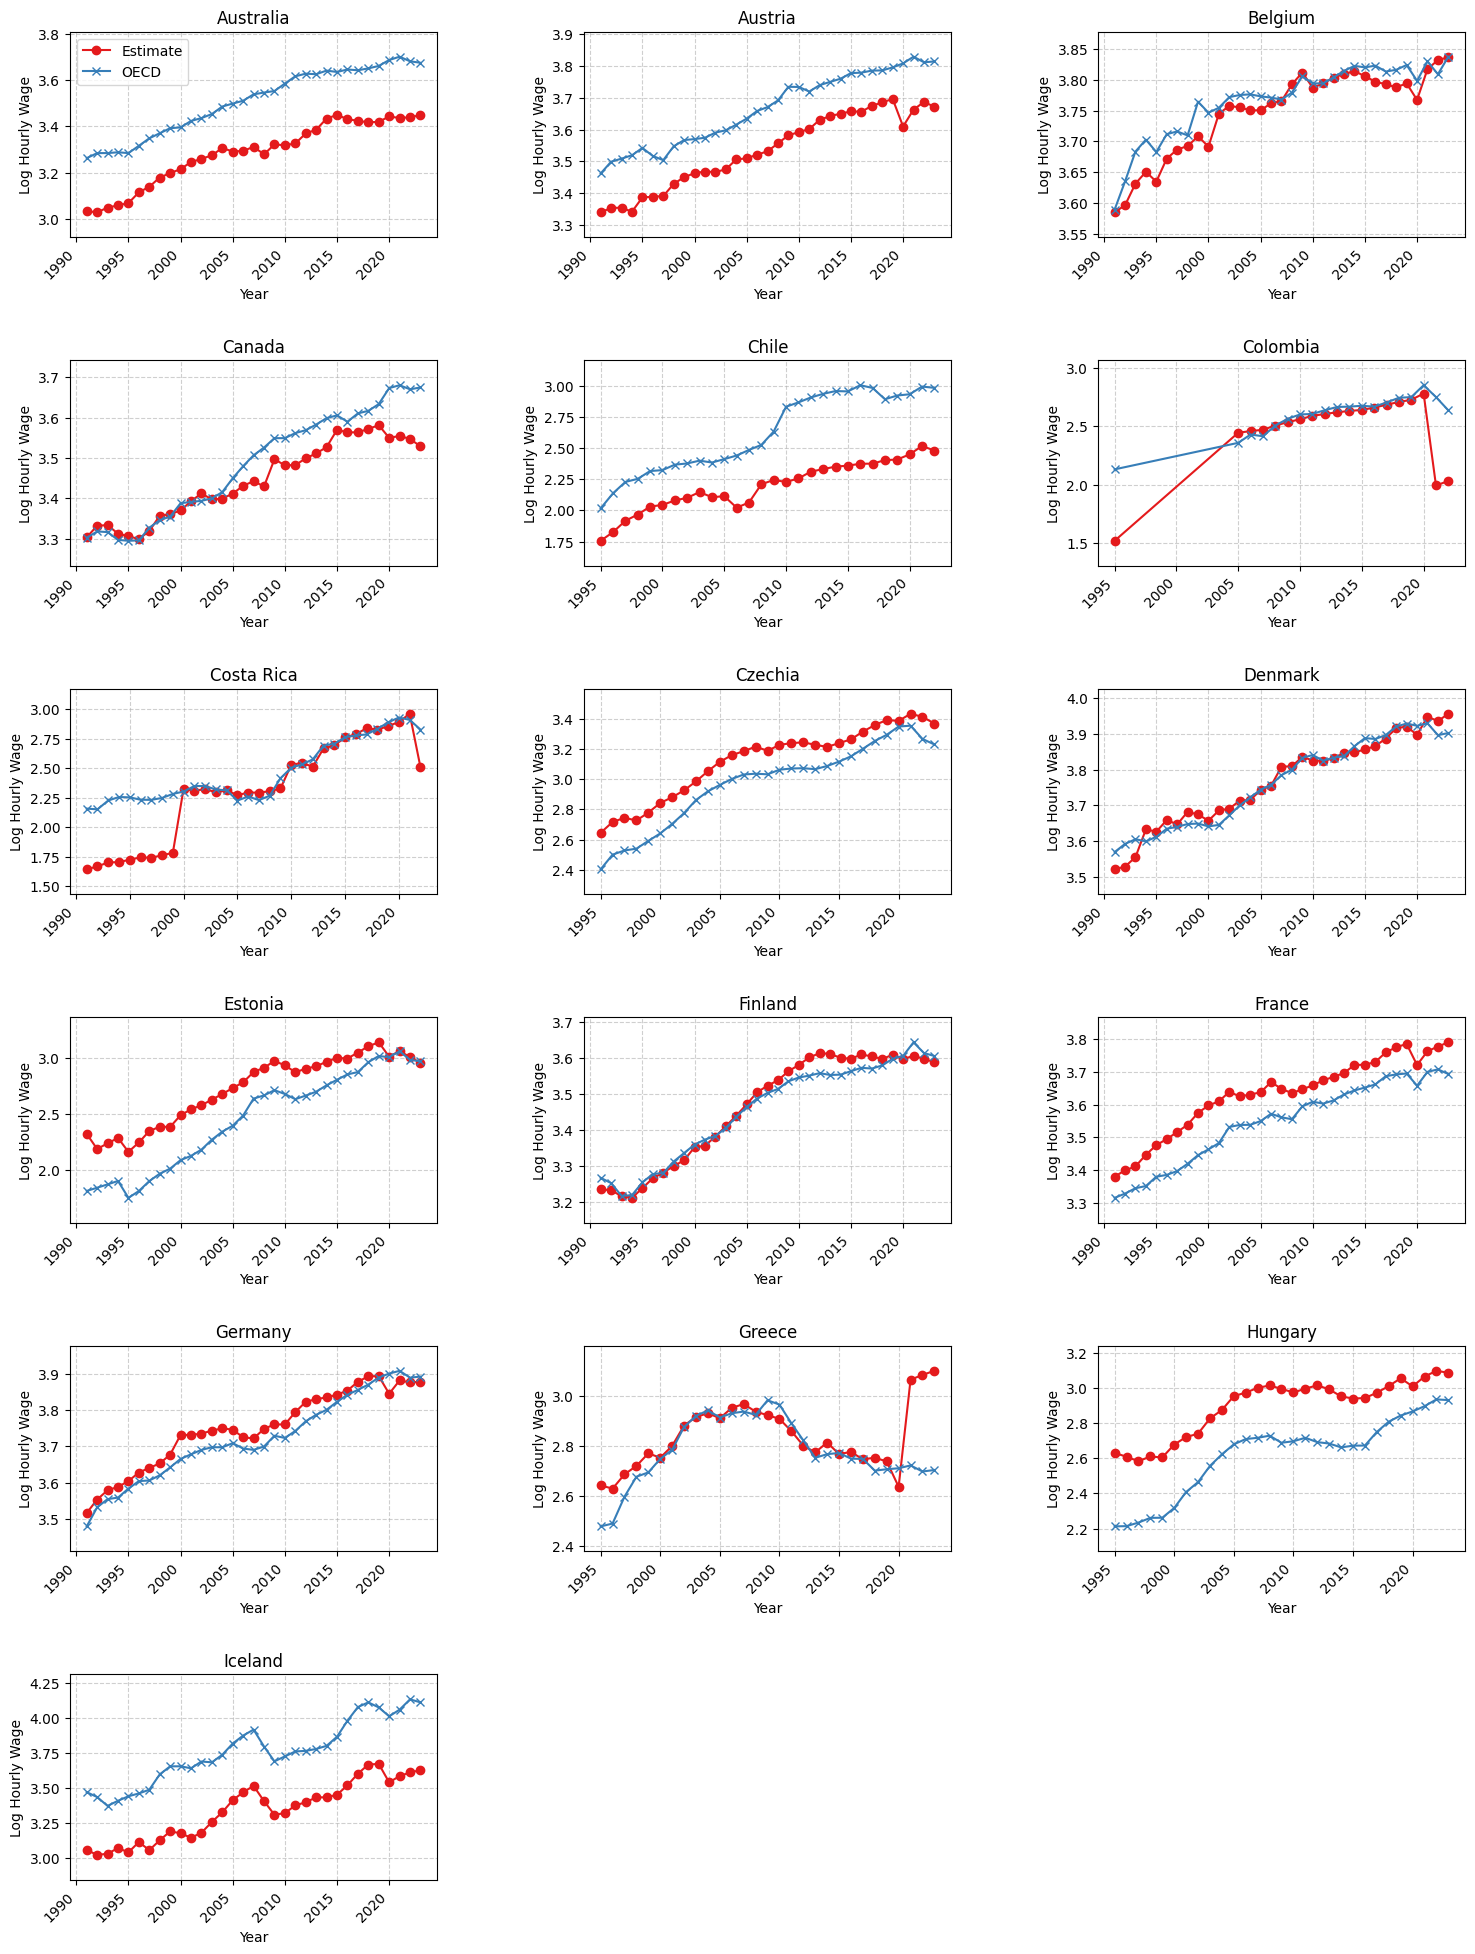

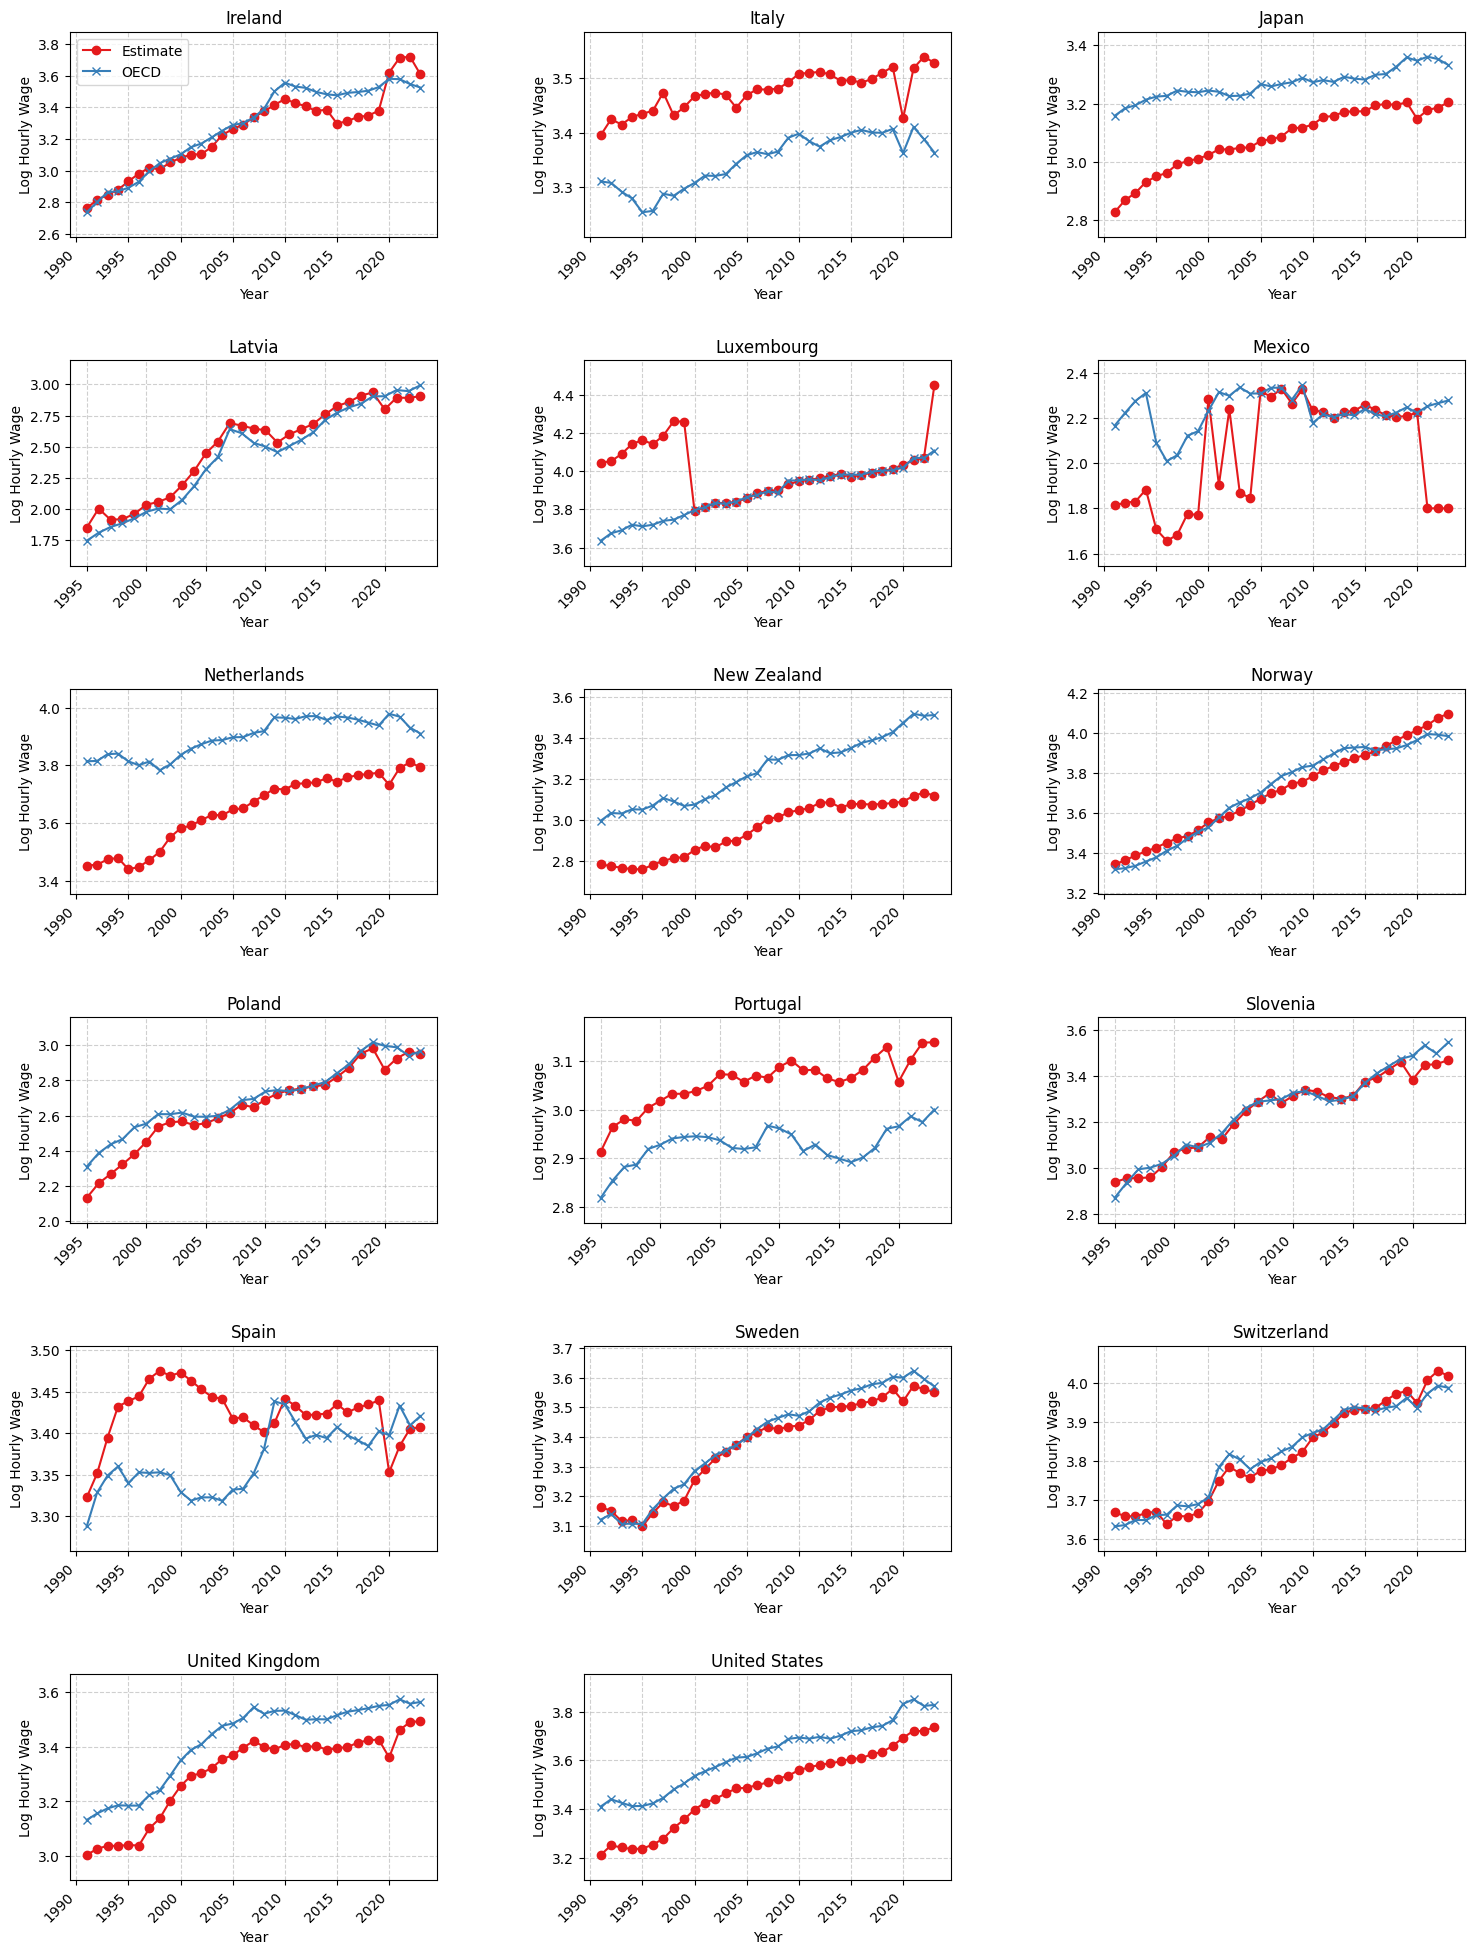

In [57]:
# — CONFIGURE THESE PATHS —
#EST_PATH  = os.path.expanduser('~/Documents/Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD.csv')
#OECD_PATH = os.path.expanduser('~/Documents/Project_Wage_Convergence/OECD_wages_merged.csv')
#OUT_DIR   = os.path.expanduser('~/Documents/Project_Wage_Convergence/Plots')
#os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load and prepare
df_est = pd.read_csv(os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/Countries_Wages_Estimates_Finals_GOOD_new.csv'))
df_oecd = pd.read_csv(os.path.expanduser('https://raw.githubusercontent.com/adbertin/salaryConvergence/main/OECD_wages_merged.csv'))
df_oecd.rename(columns={"Country":"country","Wages":"oecd_annual_wage","Year":"year"}, inplace=True)
df_oecd["year"] = pd.to_numeric(df_oecd["year"], errors="coerce")

df = pd.merge(df_est, df_oecd[["country","year","oecd_annual_wage"]],
              on=["country","year"], how="inner")
df["oecd_hourly_wage"] = df["oecd_annual_wage"] / df["whours"]
df["log_est"] = np.log(df["estimated_hourly_wage"])
df["log_oecd"] = np.log(df["oecd_hourly_wage"])

# 2) Split countries in two halves
countries = sorted(df["country"].dropna().unique())
half = len(countries)//2
batches = [countries[:half], countries[half:]]

from matplotlib.ticker import MultipleLocator

# 3) For each half, make a PDF with independent axes and 5-year ticks
for part, subset in enumerate(batches, start=1):
    n = len(subset)
    cols, rows = 3, math.ceil(n/3)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows),
                             sharex=False, sharey=False)
    axes = axes.flatten()

    for i, country in enumerate(subset):
        ax = axes[i]
        d = df[df["country"] == country].sort_values("year")

        # plot estimate vs. OECD
        ax.plot(d["year"], d["log_est"], '-o', label="Estimate", color=plt.cm.Set1(0))
        ax.plot(d["year"], d["log_oecd"], '-x', label="OECD",    color=plt.cm.Set1(1))

        # set ticks every 5 years
        start, end = d["year"].min(), d["year"].max()
        ax.set_xticks(np.arange(start - (start % 5), end + 1, 5))
        ax.xaxis.set_major_locator(MultipleLocator(5))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        ax.set_title(country, fontsize=12)
        ax.set_xlabel("Year")
        ax.set_ylabel("Log Hourly Wage")
        ax.grid(True, ls='--', alpha=0.6)
        if i == 0:
            ax.legend()

        # add 10% vertical padding
        y0, y1 = ax.get_ylim()
        dy = (y1 - y0) * 0.1
        ax.set_ylim(y0 - dy, y1 + dy)

    # hide any unused subplots
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    # adjust spacing
    plt.subplots_adjust(wspace=0.4, hspace=0.6)


    # save
    #out_pdf = os.path.join(OUT_DIR, f"wage_comparison_part{part}.pdf")
    #fig.savefig(out_pdf, dpi=300)
    #plt.close(fig)
    #print(f"Saved {out_pdf}")


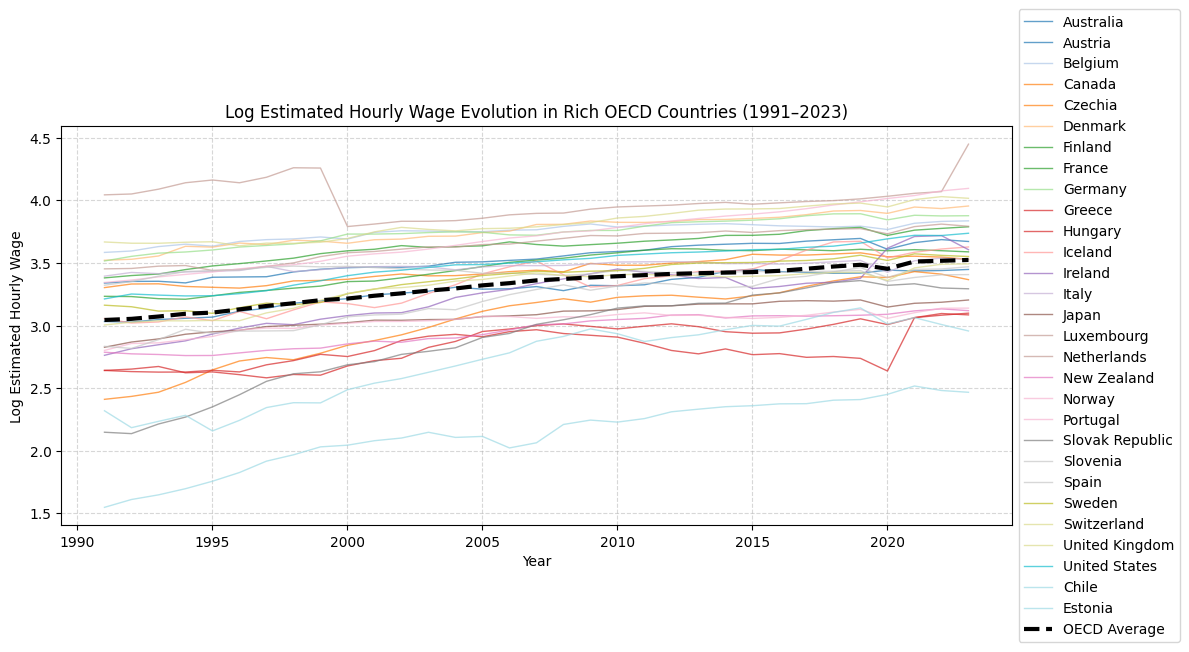

Saved plot to /root/Documents/Project_Wage_Convergence/Plots/oecd_log_wage_evolution.pdf


In [58]:
# 1) Load your estimated hourly‐wage data
#EST_PATH = os.path.expanduser('~/Documents/Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD.csv')
#df_est = pd.read_csv(EST_PATH)

# 2) Define the OECD benchmark group
oecd_countries = [
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States','Chile','Estonia'
]

# 3) Compute log of your estimated hourly wage
df_est['log_est'] = np.log(df_est['estimated_hourly_wage'])

# 4) Keep only OECD countries and pivot to wide form (years × countries)
df_oecd = df_est[df_est['country'].isin(oecd_countries)]
pivot = df_oecd.pivot(index='year', columns='country', values='log_est').sort_index()

# 5) Compute the OECD‐average log wage each year
pivot['OECD Average'] = pivot.mean(axis=1)

# 6) Plot all country lines plus the average
plt.figure(figsize=(12, 6))

# choose a qualitative colormap with enough distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, len(oecd_countries)))

for country, color in zip(oecd_countries, colors):
    if country in pivot:
        plt.plot(pivot.index, pivot[country],
                 label=country, color=color, linewidth=1, alpha=0.7)

# bold dashed line for the average
plt.plot(pivot.index, pivot['OECD Average'],
         label='OECD Average', color='k', linewidth=3, linestyle='--')

plt.xlabel('Year')
plt.ylabel('Log Estimated Hourly Wage')
plt.title('Log Estimated Hourly Wage Evolution in Rich OECD Countries (1991–2023)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# 7) Save to PDF
OUT_DIR = os.path.expanduser('~/Documents/Project_Wage_Convergence/Plots')
os.makedirs(OUT_DIR, exist_ok=True)
out_pdf = os.path.join(OUT_DIR, 'oecd_log_wage_evolution.pdf')
plt.savefig(out_pdf, dpi=300)
plt.show()

print(f"Saved plot to {out_pdf}")


In [59]:
# Identify the two countries with lowest log-wage in the final year
last = pivot.loc[pivot.index.max()]           # the 2023 row
lowest2 = last.drop('OECD Average').nsmallest(2)
print("Two countries with lowest log estimated wage in", pivot.index.max())
print(lowest2)

# --- after computing pivot and pivot['OECD Average'] ---

last_year = pivot.index.max()
last = pivot.loc[last_year]

# find the two lowest countries (excluding the average)
lowest2 = last.drop('OECD Average').nsmallest(2)

# build a small summary table
summary = pd.DataFrame({
    'log_wage':     lowest2,
    'level_wage':   np.exp(lowest2),
    'avg_level':    np.exp(last['OECD Average'])
})

# compute gap vs average in percent
summary['gap_vs_avg_%'] = (summary['avg_level'] - summary['level_wage']) / summary['avg_level'] * 100

print(f"Comparison for {last_year}:")
print(summary)


Two countries with lowest log estimated wage in 2023
country
Chile      2.467107
Estonia    2.956992
Name: 2023, dtype: float64
Comparison for 2023:
         log_wage  level_wage  avg_level  gap_vs_avg_%
country                                               
Chile    2.467107   11.788294  33.935787     65.262943
Estonia  2.956992   19.240016  33.935787     43.304641


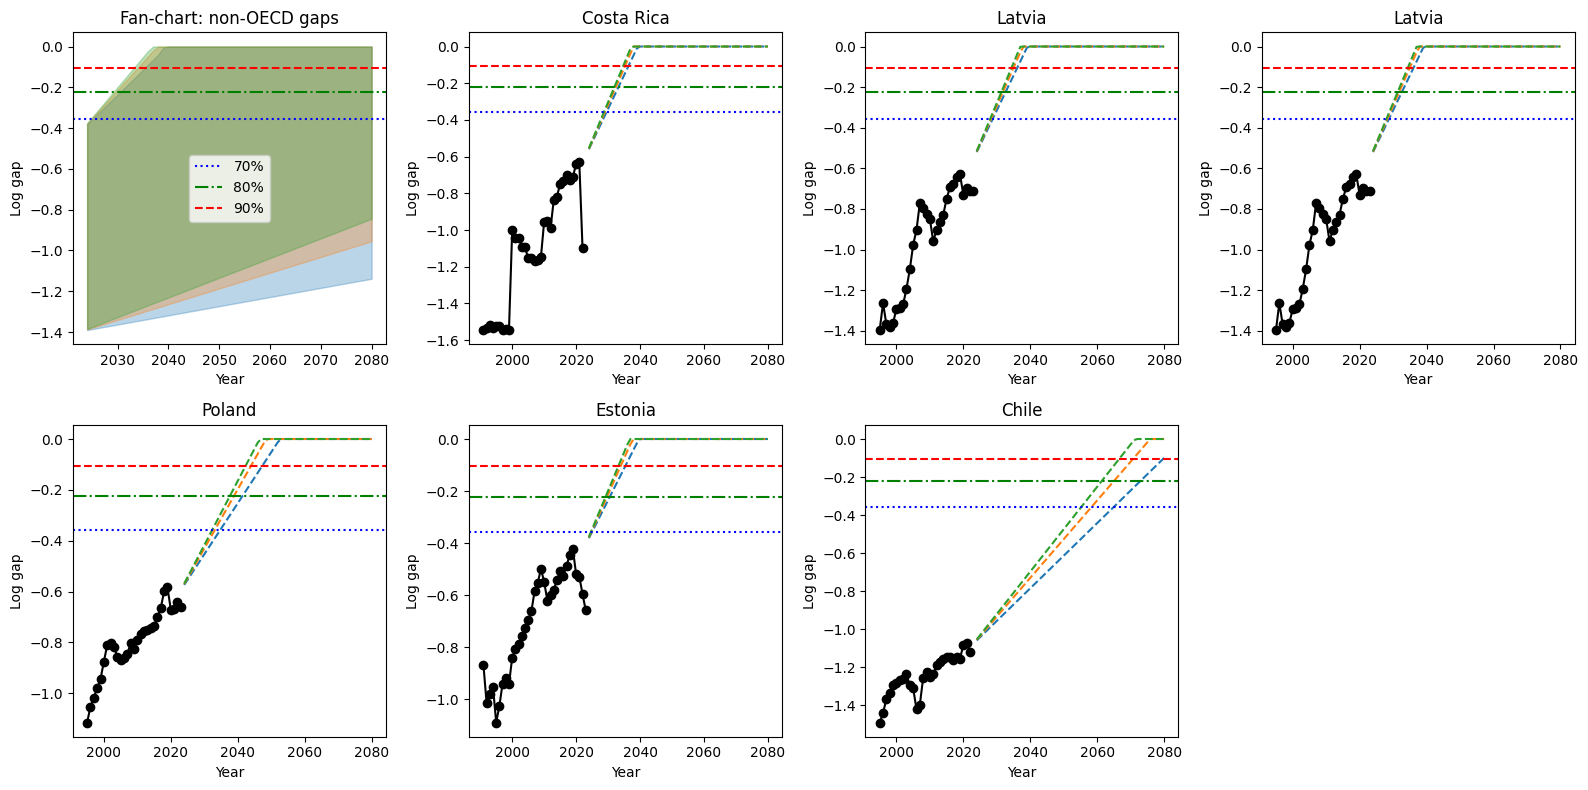

Written combined panels to /root/Downloads/combined_6countries_plus_fanchart.pdf


In [61]:
# ── INPUTS ─────────────────────────────────────────────────────────────────────
EST_CSV     = os.path.expanduser('~/Documents/Project_Wage_Convergence/Countries_Wages_Estimates_Finals_GOOD_new.csv')
BENCH_CSV   = os.path.expanduser('~/Downloads/OECD_benchmark_scenarios.csv')
SUMMARY_CSV = os.path.expanduser('~/Downloads/V30_convergence_three_scenarios_nonOECD_plateau_summary.csv')
OUT_PDF     = os.path.expanduser('~/Downloads/combined_6countries_plus_fanchart.pdf')

# ── LOAD DATA ───────────────────────────────────────────────────────────────────
df=df.copy()
df['log_wage'] = np.log(df['estimated_hourly_wage'])
df['country'] = df['country'].str.replace('\u00A0',' ').str.strip()
bench = pd.read_csv(BENCH_CSV)
res   = pd.read_csv(SUMMARY_CSV)

# build non-OECD sample
# Define the OECD set explicitly as in previous cells
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Republic','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States'
}
df2 = (df.merge(bench, on='year', how='left')
         .query("country not in @oecd")
         .dropna(subset=['benchmark_high']))

# common histogram end and forecast horizon
H_END = df2['year'].max()                  # e.g. 2023
F_YEARS = np.arange(H_END+1, bench['year'].max()+1)

# pick six examples
res['L-70_num'] = pd.to_numeric(res['L-70'], errors='coerce')
# Ensure we only select countries that are actually in df2
valid_res = res[res['country'].isin(df2['country'].unique())]

fast  = valid_res.dropna(subset=['L-70_num']).nsmallest(2,'L-70_num')['country'].tolist()
mids  = valid_res.dropna(subset=['L-70_num']).sort_values('L-70_num')
midx  = len(mids)//2
mid   = mids.iloc[midx-1:midx+1]['country'].tolist()
never = valid_res[valid_res['L-70_num'].isna()].nlargest(2,'gap_low_2080')['country'].tolist()
selected = fast + mid + never

# ── REFIT & COLLECT GAPS ────────────────────────────────────────────────────────
def get_gaps(sub):
    # fit linear trend on (year-H_END) even if shorter history
    tc = (sub['year'] - sub['year'].min()).values.reshape(-1,1)
    y  = sub['log_wage'].values
    # Check if there are enough data points for linear regression
    if len(y) < 2: # Linear regression requires at least 2 points
        return None # Return None if not enough data

    try:
        m  = LinearRegression().fit(tc, y)
    except ValueError: # Handle potential issues with fitting
        return None # Return None if fitting fails

    # hist gaps
    # Check if benchmark_high values are available for the historical years
    bench_hist_values = sub['benchmark_high'].values
    if np.isnan(bench_hist_values).any():
         # Handle cases where benchmark data is missing for historical year. Decide how to handle.For now, skip. Alternatively, calculate gh only where both wage and benchmark exist.
         gh = y - np.log(bench_hist_values)
    else:
        gh = y - np.log(bench_hist_values)


    # forecast on common horizon
    tc_f = (F_YEARS - sub['year'].min()).reshape(-1,1)
    yf   = m.predict(tc_f)
    gaps = {}
    for s in ['high','medium','low']:
        # Reindex bench dataframe to match future years
        bench_vals = bench.set_index('year').reindex(F_YEARS)[f'benchmark_{s}'].values
        # Ensure benchmark values are not NaN before calculating log
        if np.isnan(bench_vals).any():
            # Handle missing benchmark values for future years, e.g., by skipping or filling
            gaps[s] = np.full_like(yf, np.nan) # Assign NaN if future bench values are missing
        else:
            raw = yf - np.log(bench_vals)
            gaps[s] = np.minimum(raw, 0.0) # Apply plateau cap only where data is valid
            # Optionally handle NaNs introduced by log or benchmark reindexing
            gaps[s][np.isnan(gaps[s])] = np.nan # Keep NaNs if they appeared

    # Ensure all components are not None before returning
    if all(v is not None for v in gaps.values()): # Simplified check
         return sub['year'].values, gh, F_YEARS, gaps
    else:
         return None


# all non-OECD for fan - Filter out None results
gaps_all = {c: res for c, res in {c: get_gaps(df2[df2['country']==c]) for c in df2['country'].unique()}.items() if res is not None}

# Check if selected list is empty after filtering
if not selected:
    print("No countries selected for plotting after filtering based on data availability.")

# Ensure there's at least one country in gaps_all to get years_hist, years_fut
if not gaps_all:
    print("No countries with sufficient data to compute gaps. Cannot create fan chart.")
else:
    # ── PLOT 2×4 ────────────────────────────────────────────────────────────────────
    fig, axes = plt.subplots(2,4, figsize=(16,8))
    ax_fan = axes[0,0]
    others = axes.flatten()[1:7]

    # fan‐chart
    # Use the first country in gaps_all to get the years
    first_country_key = next(iter(gaps_all))
    years_hist, _, years_fut, _ = gaps_all[first_country_key]

    for scen,col in zip(['high','medium','low'],['C0','C1','C2']):
        # Stack valid gap arrays, ignoring None entries if any slipped through
        M = np.vstack([g[3][scen] for g in gaps_all.values()])

        # Handle potential NaNs in M after stacking
        M_min = np.nanmin(M, axis=0)
        M_max = np.nanmax(M, axis=0)
        ax_fan.fill_between(years_fut, M_min, M_max, color=col, alpha=0.3)

    for lvl,ls,col in [(0.7,':','blue'),(0.8,'-.','green'),(0.9,'--','red')]:
        ax_fan.axhline(np.log(lvl), ls=ls, color=col, label=f"{int(lvl*100)}%")
    ax_fan.set_title("Fan‐chart: non‐OECD gaps"); ax_fan.set_xlabel("Year"); ax_fan.set_ylabel("Log gap")
    ax_fan.legend()

    # country panels
    plotted_countries = 0
    for ax,c in zip(others, selected):
        if c in gaps_all: # Double check if the selected country has valid gaps
            yh, gh, yf, gf = gaps_all[c]
            ax.plot(yh, gh, 'k-o')
            for scen,col in zip(['high','medium','low'],['C0','C1','C2']):
                # Plot forecast lines, handling potential NaNs
                ax.plot(yf, gf[scen], '--', color=col)
            for lvl,ls,col in [(0.7,':','blue'),(0.8,'-.','green'),(0.9,'--','red')]:
                ax.axhline(np.log(lvl), ls=ls, color=col)
            ax.set_title(c); ax.set_xlabel("Year"); ax.set_ylabel("Log gap")
            plotted_countries += 1
        else:
             # Hide unused axes if selected countries don't have data
             ax.set_visible(False)

    # Hide any remaining unused axes
    for j in range(plotted_countries, len(others)):
        others[j].set_visible(False)

    axes[1,3].set_visible(False) # Hide the 8th subplot position as it's not used for a country
    plt.tight_layout()
    plt.savefig(OUT_PDF, dpi=300)
    plt.show()

    print("Written combined panels to", OUT_PDF)